In [1]:
import numpy as np
import pickle
import sys
sys.path.append('/work4/clf/Josh/Bayesian/hyades_species_pso')
import pso_Analysis as Analysis
from pso import Pso
import os
import subprocess
import time
import scipy as sp
from scipy.stats import qmc
from scipy.optimize import linear_sum_assignment
import random
import numpy as np
import sys
from sklearn.neighbors import NearestNeighbors
import logging
import datetime as datetime

def GenerateY (X):

    # ======------- - - - - - ---------======== #

    def GetResult(simulation_CDF_file, verbose=False):
        """
        Function to be optimised. Can make use of the BOA_Helpers/Analysis.py file which contains some pre-made alaysis functions.

        Parameters:
        simulation_CDF_file (string): path to the cdf file
        raw_X (1d array): the input parameters

        Returns:
        [result] (list of floats): a list of Y values to return to BOA
        """

        # If CDF file exists analyse.
        try:
            # Pull important values from the simulation
            gain_data = Analysis.Gain(simulation_CDF_file)
            CR_data = Analysis.ConvergenceRatio(simulation_CDF_file)
            IFAR_data = Analysis.IFAR(simulation_CDF_file)
            velocity_data = Analysis.ImplosionVelocity(simulation_CDF_file)

            gain = gain_data[0]
            CR = np.max(CR_data[0])
            IFAR = IFAR_data[0][IFAR_data[1]]
            velocity = abs(min(velocity_data[0]))
            parametric_limit = Analysis.LaserProfile(simulation_CDF_file)[2]
            

            def Get_multiplier (x, X_cutoff, half=False):
                if half==False:
                    frac_x = (x - X_cutoff)/(0.25*X_cutoff)
                    # print(frac_x)
                    a = 0.9644
                    b = 13
                    return (1/a)*(1 - (1/(1 + np.exp(-(b*frac_x - 3.3)))))
                else:
                    frac_x = (x - X_cutoff)/(0.25*X_cutoff)
                    # print(frac_x)
                    a = 0.9644
                    b = 13
                    return (1/a)*(1 - (1/(1 + np.exp(-(2*b*frac_x - 3.3)))))

            # Reduce effective gain if CR is above 13. Reduces result by 1/e at a CR of 17
            if CR > 13:
                #CR_multiplier = np.exp(- (CR - 13) / (17 - 13))
                CR_multiplier = Get_multiplier(CR, 13)
            else:
                CR_multiplier = 1

            # Reduce effective gain if IFAR is above 30. Reduces result by 1/e at an IFAR of 40
            if IFAR > 30:
                #IFAR_multiplier = np.exp(- (IFAR - 30) / (40 - 30))
                IFAR_multiplier = Get_multiplier(IFAR, 30)
            else:
                IFAR_multiplier = 1

            # Reduce effective gain if IFAR is above 30. Reduces result by 1/e at an IFAR of 500
            if velocity > 400:
                #velocity_multiplier = np.exp(- (velocity - 400) / (500 - 400))
                velocity_multiplier = Get_multiplier(velocity, 400, half=True)
            else:
                velocity_multiplier = 1

            # Reduce effective gain if IFAR is above 1e14. Reduces result by 1/e at an parametric limit values of 2e14
            if parametric_limit > 1e14:
                # parametric_limit_multiplier = np.exp(- (parametric_limit - 1e14) / (2e14 - 1e14))
                parametric_limit_multiplier = Get_multiplier(parametric_limit, 1e14)
            else:
                parametric_limit_multiplier = 1

            # Combine all multipliers into a single value. This is where instability is factored into the loss function.
            result = gain * CR_multiplier * IFAR_multiplier * velocity_multiplier * parametric_limit_multiplier

        except:
            result = 0.0

        return result
        
        # ======------- - - - - - ---------======== #

    sample_points = X.reshape(number_of_particles, SampleSizeFunction(iteration), dimension)

    pso_helper.current_run = 0
    pso_helper.logger.info(f'Starting Run 0')
    pso_helper.Make_Swarm_Iteration_Dir()
    pso_helper.Make_Run_Iteration_Dir()
    pso_helper.run_size = pso.SampleSizeFunction(iteration)
    for p in range(number_of_particles):
        pso_helper.WriteSubfile(run_dir=f'{pso_helper.output_directory}/P{p}/SI{iteration}/R{0}', run_size=SampleSizeFunction(iteration), simulation_time='03:00:00')
        pso_helper.CreateSimulationDirectories(sample_points[p], p)

    pso_helper.RunShellScript()

    while not pso_helper.Check_Hyades_Done():
        if pso_helper.Check_PPFs_Made() == True:
            pso_helper.logger.info('All Hyades jobs have been submitted!')
            pso_helper.logger.info('Waiting for the last jobs to finish...')
            # Break the long sleep into shorter intervals
            total_sleep_time = 3.2 * 3600  # 3.2 hours in seconds
            interval = 120  # Interval to check the condition in seconds
            start_time = time.time()

            while time.time() - start_time < total_sleep_time:
                time.sleep(interval)
                if pso_helper.Check_Hyades_Done():
                    break
            pso_helper.Manually_Make_CDFs()
        else:
            time.sleep(120)

    Y = []
    for p in range(number_of_particles):
        for sim in range(SampleSizeFunction(iteration)):
            Sim_CDF_File = f"{pso_helper.output_directory}/P{p}/SI{iteration}/R{0}/S{sim}/input{sim}.cdf"
            Y.append(GetResult(Sim_CDF_File))
    return Y

use_adaptive_boxes = True

def LocalWeightFunction (iteration):
    return

def GlobalWeightFunction (iteration):
    return 

def InertialWeightFunction (iteration):
    return

use_adaptive_boxes = True
use_species = True
species_weights = [0.4, 0.4, 0.1, 0.1]

use_boxes_cutoff = 1
box_reduction_factor = 0.8

def BoxWidthFunction(iteration):
    if iteration < use_boxes_cutoff:
        return (box_reduction_factor**(iteration))*(bounds[0][1] - bounds[0][0])
    else:
        use_adaptive_boxes = False
        return 0.0001

def SampleSizeFunction(iteration):
    if iteration < use_boxes_cutoff:
        return 5
    else:
        return 1

use_explosive_global_parameter = False

with open('/work4/clf/Josh/Bayesian/hyades_species_pso/pso.pkl', 'rb') as file:
    my_pso = pickle.load(file)

THIS IS 100% THE RIGHT ANALYSIS FILE!!!


0.1663951742454558
[0.29015137 0.7445482  0.47595055 0.21729638 0.38756883 0.61259431
 0.92674864]
Particle with GMAX = 76
Simulation with GMAX = 0
[0.29200717 0.74460462 0.47562242 0.21712006 0.38947217 0.61367455
 0.92621211]


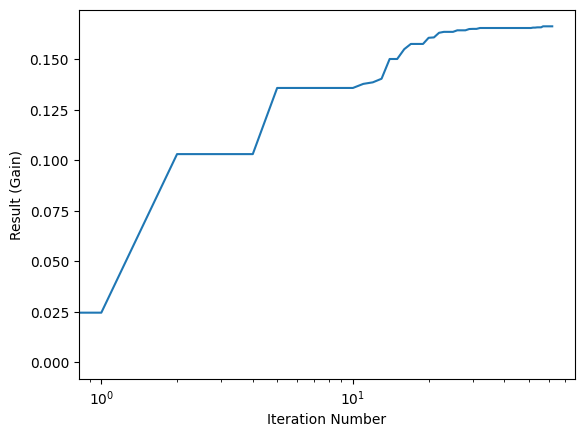

In [2]:
import matplotlib.pyplot as plt

simulation_numbers = np.add(750*np.ones(len(my_pso.swarm.global_max_history)), 250*np.arange(len(my_pso.swarm.global_max_history)))

gmax_history = my_pso.swarm.global_max_history
gmax_history.insert(0,0)

plt.figure()
plt.xlabel('Iteration Number')
plt.ylabel('Result (Gain)')
plt.xscale('log')
#plt.plot(simulation_numbers, my_pso.swarm.global_max_history)
plt.plot(np.arange(len(gmax_history)), gmax_history)

print(my_pso.swarm.global_max)
print(my_pso.swarm.global_max_loc)
print(f'Particle with GMAX = {my_pso.swarm.global_max_particle_index}')
print(f'Simulation with GMAX = {my_pso.swarm.global_max_sample_index}')
print(my_pso.swarm.particles[25].local_max_loc)

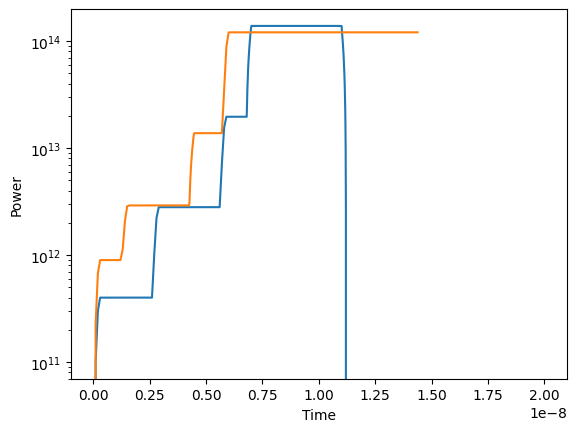

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

plt.figure()

file = '/work4/clf/jordanlee/Hyades/SummerProject/ExampleHotspot/Data/TestInputDeck.cdf'
data = nc.Dataset(file)
Times = np.array(data['DumpTimes']) * 1e9 # Time (ns)
SimulationLaserPower, ExperimentalLaserPower, ParametricLimit = Analysis.LaserProfile(file)

file2 = '/work4/clf/Josh/Bayesian/hyades_species_pso/GMax4/S0/input0.cdf'
data2 = nc.Dataset(file2)
Times2 = np.array(data['DumpTimes']) * 1e9 # Time (ns)
SimulationLaserPower2, ExperimentalLaserPower2, ParametricLimit2 = Analysis.LaserProfile(file2)

plt.plot(np.array(data['DumpTimes']), SimulationLaserPower)
plt.plot(np.array(data2['DumpTimes']), SimulationLaserPower2)

# Removing default ticks


# Adding custom ticks with variable names
# plt.xticks(
#     [laser2_start_time, laser3_start_time, laser4_start_time],
#     ['X[0]', 'X[1]', 'X[2]']
# )
# plt.yticks(
#     [laser1_power, laser2_power, laser3_power, laser4_power],
#     ['X[3]', 'X[4]', 'X[5]', 'X[6]']
# )

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Power')
plt.yscale('log')

# Show plot
plt.show()


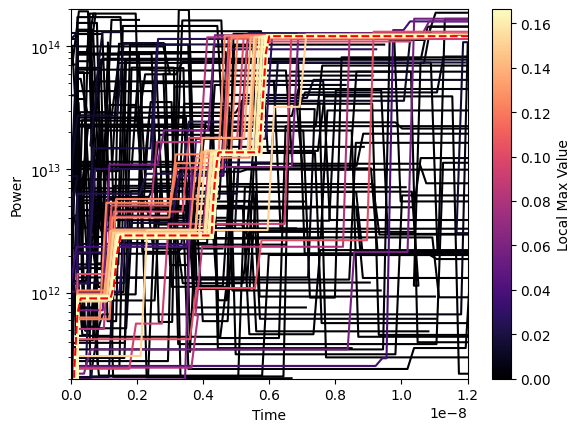

In [4]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Set up figure and axis
fig, ax = plt.subplots()

# Get local max values and sort particles by their local_max value
particles_with_max = [(particle, particle.local_max) for particle in my_pso.swarm.particles]
particles_with_max_sorted = sorted(particles_with_max, key=lambda x: x[1])  # Sort by local_max

# Extract sorted local_max values
local_max_sorted = [p[1] for p in particles_with_max_sorted]

# Normalize local max values to range between 0 and 1
norm = Normalize(vmin=min(local_max_sorted), vmax=max(local_max_sorted))

# Create a colormap (you can change 'viridis' to other colormaps like 'plasma', 'inferno', etc.)
colormap = cm.magma

# Plot each particle's pulse with color corresponding to its local_max value
for particle, local_max_val in particles_with_max_sorted:
    # Data preparation
    raw_X = particle.local_max_loc

    laser4_start_time = raw_X[2] * 12e-9
    laser3_start_time = raw_X[1] * laser4_start_time
    laser2_start_time = raw_X[0] * laser3_start_time
    laser1_start_time = 2.000e-10

    # Forcing Laser Power to take expected pulse shape
    laser1_power = 2 * 10**(18 + (raw_X[3] * 3)) * 10e-8
    laser2_power = 2 * 10**(18 + (raw_X[4] * 3)) * 10e-8
    laser3_power = 2 * 10**(18 + (raw_X[5] * 3)) * 10e-8
    laser4_power = 2 * 10**(18 + (raw_X[6] * 3)) * 10e-8
    
    # laser3_power = raw_X[5] * laser4_power
    # laser2_power = raw_X[4] * laser3_power
    # laser1_power = raw_X[3] * laser2_power

    # Laser profile data
    LaserPlot = np.array([
        [0, 0],
        [laser1_start_time, laser1_power],
        [laser2_start_time, laser1_power],
        [laser2_start_time + 0.2e-9, laser2_power],
        [laser3_start_time, laser2_power],
        [laser3_start_time + 0.2e-9, laser3_power],
        [laser4_start_time, laser3_power],
        [laser4_start_time + 0.2e-9, laser4_power],
        [2 * laser4_start_time, laser4_power]
    ])

    timings = LaserPlot[:, 0]
    powers = LaserPlot[:, 1]

    # Get color for the current particle based on local_max
    color = colormap(norm(local_max_val))

    # Plot with corresponding color
    ax.plot(timings, powers, linestyle='-', color=color)

#ax.plot(np.array(data['DumpTimes']), SimulationLaserPower, color='lime')
ax.plot(np.array(data2['DumpTimes']), SimulationLaserPower2, color='r', linestyle='--')
# Adding labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Power')
ax.set_yscale('log')
ax.set_xlim(0, 1.2e-8)
ax.set_ylim(2e11, 2e14)

# Create a ScalarMappable and attach the colormap to it for the colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable

# Show color bar to indicate local max values
fig.colorbar(sm, ax=ax, label='Local Max Value')

# Show plot
plt.show()

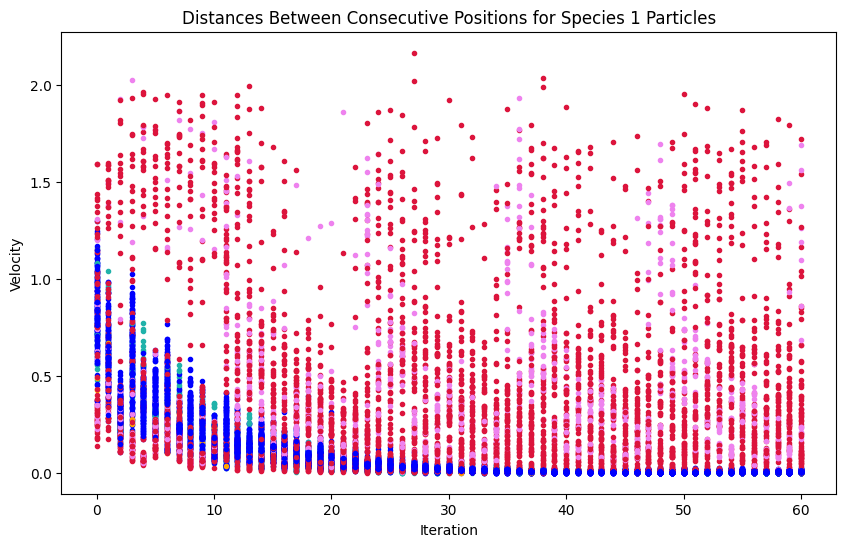

In [5]:
plt.figure(figsize=(10, 6))

colors = ['lightseagreen', 'crimson', 'violet', 'orange', 'blue']

# Loop through all particles in the swarm
for particle in my_pso.swarm.particles:
    if particle.species != 10:
        distances = []
        
        # Calculate distances between consecutive positions for this particle
        for i in range(len(particle.position_history) - 1):
            dist = np.linalg.norm(np.array(particle.position_history[i + 1]) - np.array(particle.position_history[i]))
            distances.append(dist)
        
        # Plot the distances for this particle
        plt.scatter(np.arange(len(distances)), distances, marker='.', c=colors[particle.species])
        # plt.plot(distances, marker='.', linestyle='-', c=colors[particle.species])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Velocity')
plt.title('Distances Between Consecutive Positions for Species 1 Particles')
plt.show()


In [6]:
# sample_point_iterations = [i for i in range(my_pso.current_iteration) for _ in range(SampleSizeFunction(i))]

# for d in range(my_pso.dimension):
#     plt.figure()
#     plt.ylim(0, 1)
#     for particle in my_pso.swarm.particles:
#         for s, sample_point in enumerate(particle.sample_points_history):
#             plt.scatter(sample_point_iterations[s], sample_point[d], marker='.', c=colors[particle.species])
#     plt.show()

In [7]:
Positions = []
Results = []
Species = []
for particle in my_pso.swarm.particles:
    for loc in particle.local_max_history_loc:
        Positions.append(loc)
        Species.append(particle.species)
    for result in particle.local_max_history:
        Results.append(result)
    

Results = np.array(Results)

# Get the indices that would sort Results
sorted_indices = np.argsort(Results)

# Use these indices to sort both Results and Positions
sorted_Results = Results[sorted_indices]
sorted_Positions = np.array(Positions)[sorted_indices]  # Convert Positions to NumPy array
sorted_Species = np.array(Species)[sorted_indices]

# If you need them as lists
sorted_Results = sorted_Results.tolist()
sorted_Positions = sorted_Positions.tolist()
sorted_Species = sorted_Species.tolist()

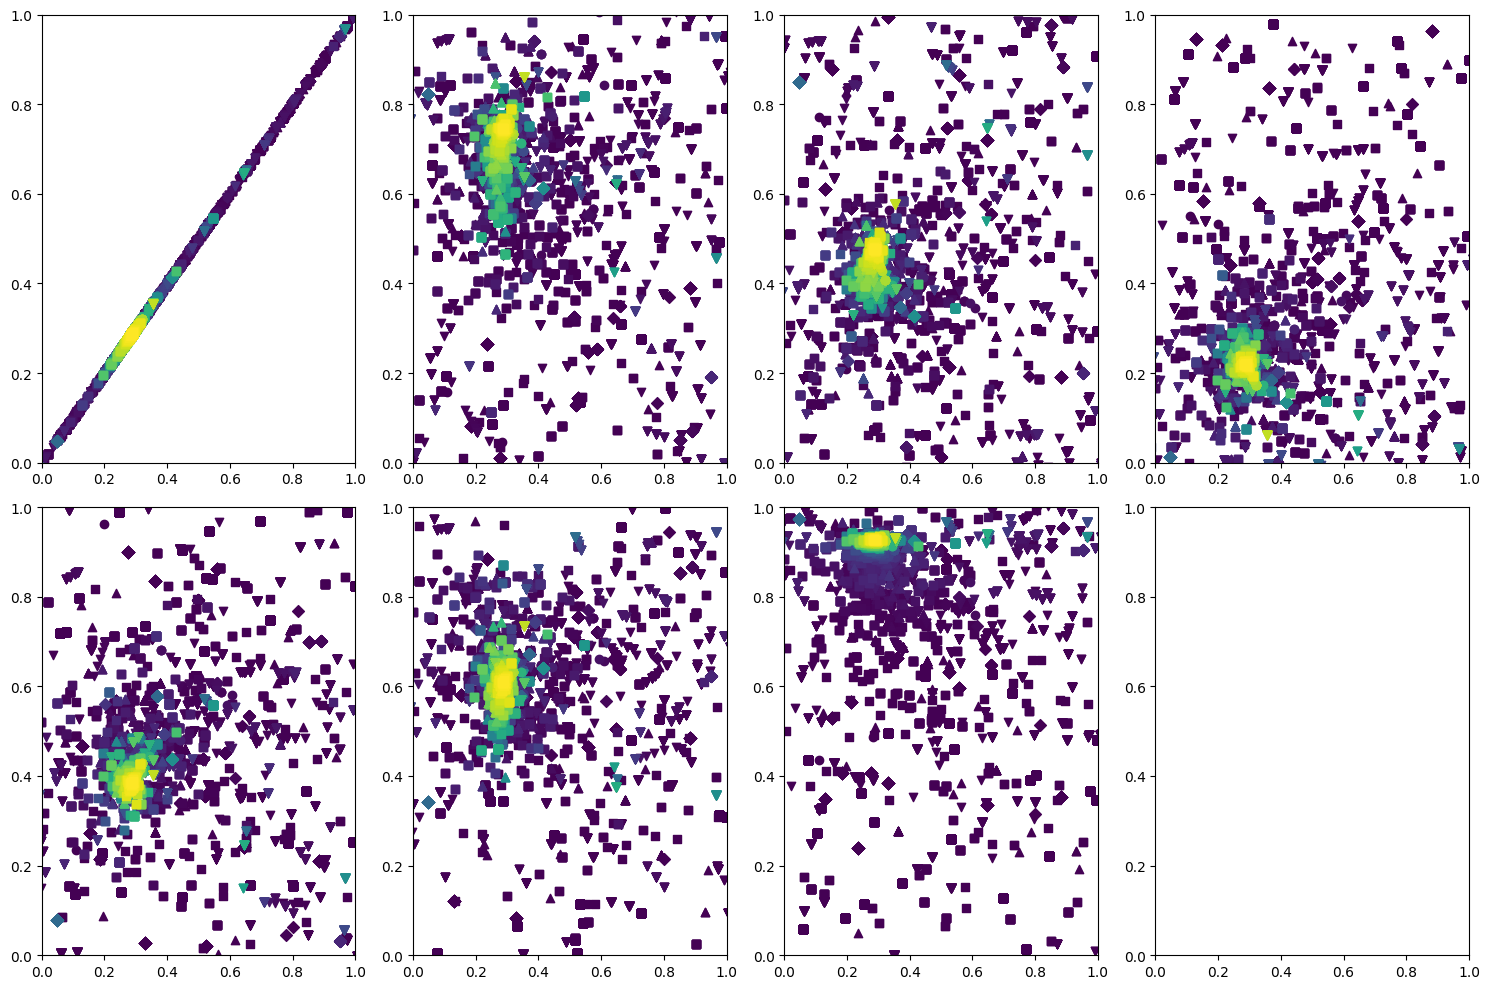

In [8]:
import matplotlib.pyplot as plt

# Define the markers for each species
species_markers = {
    0: '^',  # Circle
    1: 'v',  # Square
    2: 'D',  # Diamond
    3: 'o',  # Triangle up
    4: 's'   # Triangle down
}

# Set bounds
xmin = ymin = 0
xmax = ymax = 1

fig, axs = plt.subplots(2, 4, figsize=(15, 10))  # 2 rows, 4 columns
cmap = plt.get_cmap('viridis')

for i, result in enumerate(sorted_Results):
    color = cmap(result / my_pso.swarm.global_max)
    
    # Select the marker for the current species
    marker = species_markers[sorted_Species[i]]
    
    axs[0, 0].scatter(sorted_Positions[i][0], sorted_Positions[i][0], color=color, marker=marker)
    axs[0, 1].scatter(sorted_Positions[i][0], sorted_Positions[i][1], color=color, marker=marker)
    axs[0, 2].scatter(sorted_Positions[i][0], sorted_Positions[i][2], color=color, marker=marker)
    axs[0, 3].scatter(sorted_Positions[i][0], sorted_Positions[i][3], color=color, marker=marker)
    axs[1, 0].scatter(sorted_Positions[i][0], sorted_Positions[i][4], color=color, marker=marker)
    axs[1, 1].scatter(sorted_Positions[i][0], sorted_Positions[i][5], color=color, marker=marker)
    axs[1, 2].scatter(sorted_Positions[i][0], sorted_Positions[i][6], color=color, marker=marker)

# Set limits for x and y axes
for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()
